# Word Embedding Alignment

In [2]:
#import libraries
import numpy as np
import pandas as pd
import random
import gensim
from gensim.models import KeyedVectors
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import warnings
%matplotlib inline
warnings.filterwarnings("ignore")

## 1. Read Vocabularies From Emebddings and Subset Bilingual Vocabularies

#### Use this code to extract from source and target vocabularies n words that appear in both 
#### Note: Skip this part if you use the toy data in the folder "embedding/alignemnt/toy_data"

In [ ]:
# read source vocabulary
source_vocabulary_embeddings = KeyedVectors.load_word2vec_format(PATH_EMBEDDING_SOURCE)
# read target vocabulary
target_vocabulary_embeddings = KeyedVectors.load_word2vec_format(PATH_EMBEDDING_TARGET)

In [ ]:
# get list of tokens from source and target vocabularies (i.e. words in the vocabulary) 
words_src = []
for word_src in source_vocabulary_embeddings.vocab:
    words_src.append(word_src)

words_trg = []
for word_trg in target_vocabulary_embeddings.vocab:
    words_trg.append(word_trg)

# Summary Source
print("Number of Tokens in source: {}".format(len(words_src)))
print("Dimension of a word vector source embeddings: {}".format(len(source_vocabulary_embeddings[words[0]])))

# Summary Target
print("Number of Tokens in target: {}".format(len(words_it)))
print("Dimension of a word vector target embeddings: {}".format(len(target_vocabulary_embeddings[words[0]])))

In [ ]:
# Create dictionary with words index
# Source
word_to_index_en = {}
i=0
for word, _ in source_vocabulary_embeddings.vocab.items():
    word_to_index_en[word] = i
    i=i+1
print("This is the index of the word you are looking int the source: {}".format(word_to_index_eng[WORD_TO_CHECK_SOURCE]))

# Target
word_to_index_it = {}
i=0
for word, _ in target_vocabulary_embeddings.vocab.items():
    word_to_index_it[word] = i
    i=i+1
print("This is the index of the word you are looking int the target: {}".format(word_to_index_eng[WORD_TO_CHECK_TARGET]))

In [ ]:
def toy_data(source_vocabulary, target_vocabulary, n_words):
    """Function to extract bilingual vocabulary from source and target vocabularies. 
    It returns two dictionaries (i.e. source and target languages) with same keys."""

    #create a dictionary of overlapping words
    source_words = set(source_vocabulary.index2word)
    target_words = set(target_vocabulary.index2word)
    overlap = list(source_words & target_words)
    bilingual_vocabulary = [(entry, entry) for entry in overlap]
    
    #select a random number of words from the bilingual dictionary
    pair_words = random.sample(bilingual_vocabulary, n_words)
    toy_words = [tup[0] for tup in pair_words]
    
    #store vector for each word in two dictionaries (source and target)
    source_dictionary = dict()
    target_dictionary = dict()
    for word in toy_words:
        source_dictionary[word] = source_vocabulary.get_vector(str(word))
        target_dictionary[word] = target_vocabulary.get_vector(str(word))
    
    return source_dictionary, target_dictionary

In [ ]:
# generate toy data eng_pt
source_dictionary, target_dictionary = toy_data(source_vocabulary_embeddings, target_vocabulary_embeddings, 20000)
# check if lenght among source and target matches
print("The two subsets have equal number of entries: {}".format(len(source_dictionary.keys()) == len(target_dictionary.keys())))

## 1.a Load Data in the folder "embedding/alignemnt/toy_data"

#### Use this code to load source and target vocabularies

In [33]:
# Read from file
vocabulary_source = np.load('toy_data/toy_data_it-eng_20000.npy').item()
vocabulary_target = np.load('toy_data/toy_data_eng-it_20000.npy').item()
#check if the words are the same in the two vocabulary
print("The two vocabularies have same number of words: {}".format(vocabulary_source.keys() == vocabulary_target.keys()))

The two vocabularies have same number of words: True


## 2. Split Train and Test Data

In [4]:
def split_toy_data_train_test(source_dictionary, target_dictionary, ratio_train_test):
    """Function to split source and target dictionaries in train and test. 
    It returns train and test matrices for both source and target languages."""
    
    #prepare the matrix
    source_matrix = list(source_dictionary.values())
    target_matrix = list(target_dictionary.values())
    
    #select split ratio and random indices
    indices = np.random.permutation(len(source_matrix))
    ratio_train_test = ratio_train_test
    split_range = int(len(source_matrix) * ratio_train_test)
    training_idx, test_idx = indices[:split_range], indices[split_range :]

    #select by indices train and test for source and target dictionaries
    source_train = np.array([source_matrix [i] for i in training_idx])
    source_test = np.array([source_matrix[i] for i in test_idx])
    target_train = np.array([target_matrix[i] for i in training_idx])
    target_test = np.array([target_matrix[i] for i in test_idx])
    
    return source_train, source_test, target_train, target_test

In [14]:
# split vocabularies in train and test
source_train, source_test, target_train, target_test = split_toy_data_train_test(vocabulary_source, vocabulary_target, 0.7)
# check vocabularies size
print("The two vocabularies size are:\nsource_train {}; source_test {}; target_train {}; target_test {}.".format(source_train.shape, source_test.shape, target_train.shape, target_test.shape))

The two vocabularies size are:
source_train (14000, 300); source_test (6000, 300); target_train (14000, 300); target_test (6000, 300).


## 3. Learn Transformation to Align Embeddings

In [15]:
def normalized(a, axis=-1, order=2):
    """Utility function to normalize the rows of a numpy array."""
    
    l2 = np.atleast_1d(np.linalg.norm(a, order, axis))
    l2[l2==0] = 1
    
    return a / np.expand_dims(l2, axis)

In [16]:
def learn_transformation(source_matrix, target_matrix, normalize_vectors=True):
    """
    Source and target matrices are numpy arrays, shape
    (dictionary_length, embedding_dimension). These contain paired
    word vectors from the bilingual dictionary.
    """
    
    # normalize the training vectors
    if normalize_vectors:
        source_matrix = normalized(source_matrix)
        target_matrix = normalized(target_matrix)

    # perform SVD
    product = np.matmul(source_matrix.transpose(), target_matrix)
    U, s, V = np.linalg.svd(product)

    # return orthogonal transformation which aligns source language to the target
    return np.matmul(U, V)

In [17]:
def apply_transform(transformation, source_test):
    """ Apply the given transformation to the vector space. 
    It returns predictions given transformations with embeddings E: E = E * transform """
    
    return np.matmul(source_test, transformation)

In [18]:
# learn the transformation
transformation = learn_transformation(source_train, target_train, normalize_vectors = True)
# apply transformation on the test of the source language
source_transformed = apply_transform(transformation, source_test)

## 4. Evaluate Transformation

In [19]:
def cosine_similarity(vec_a, vec_b):
    """Compute cosine similarity between vec_a and vec_b"""
    
    return np.dot(vec_a, vec_b) / \
        (np.linalg.norm(vec_a) * np.linalg.norm(vec_b))

In [20]:
def evaluate_proximity(source_transformed, target_test, close_neighbors, metric):
    """Compute accuracy, cosine similarity and euclidian distance between the closest transformed vectors.
    INPUT:
    close_neighbors: choose number of neighbors
    metric: 'euclidian' or 'cosine' to compute kNN neighbors
    source_tranformed: test set of the source language after transformation
    target_test: test set of the target language
    
    OUTPUT:
    accuracy: percentage of matching words, within k neighbors, between source and target language after the alignment
    cosine_similarity: angolar distance among matching words
    l2_norm_distance: euclidian distance among matching words"""

    distance_embeddings = []
    accuracy = []
    similarity = []
    distance = []

    #fit model to find the closest vectors to tranformed one
    neighbors = NearestNeighbors(n_neighbors = close_neighbors, metric = metric)
    neighbors.fit(target_test)

    for i in range(0,source_transformed.shape[0]):
        index_transformed = i
        #distance between two vocabularies
        distance_embeddings.append(np.linalg.norm(source_transformed[i] - target_test[i]))
        #find vectors in the target vocabulary
        idx_neighbors_target = ((neighbors.kneighbors(source_transformed[index_transformed,:].reshape(1, -1)))[1][0]).tolist()
        #evaluate proximity among target and transformed vectors
        if index_transformed in idx_neighbors_target:
            accuracy.append('True')
            similarity.append(cosine_similarity(source_transformed[index_transformed], target_test[index_transformed]))
            distance.append(np.linalg.norm(source_transformed[index_transformed] - target_test[index_transformed]))
        else:
            accuracy.append('False')

    return [np.mean(distance_embeddings), round(accuracy.count('True')/len(accuracy)*100,2), np.mean(similarity), np.mean(distance)]

In [21]:
def evaluate(source_test, source_transformed, target_test):
    """Evalaute alignment comparing the source vocabulary and its transformed version with the target vocabulary.
    INPUT:
    source_test: vocabulary of the source language
    source_transformed: test set of the source language after transformation
    target_test: test set of the target language
    
    OUTPUT:
    dictionaries evaluating the alignment with different metrics"""
    
    sources = [source_test, source_transformed]
    metrics = ['cosine', 'euclidean']
    neighbors = [1,5,10]
    evaluation_before_cosine = dict()
    evaluation_before_euclidean = dict()
    evaluation_after_cosine = dict()
    evaluation_after_euclidean = dict()

    for source in sources:
        if source[0][0] == source_test[0][0]:
            for metric in metrics:
                if metric == 'cosine':
                    for neighbor in neighbors:
                        evaluation_before_cosine[neighbor] = evaluate_proximity(source_test, target_test, neighbor, 'cosine')

                else:
                    for neighbor in neighbors:
                        evaluation_before_euclidean[neighbor] = evaluate_proximity(source_test, target_test, neighbor, 'euclidean')

        else:
            for metric in metrics:
                if metric == 'cosine':
                    for neighbor in neighbors:
                        evaluation_after_cosine[neighbor] = evaluate_proximity(source_transformed, target_test, neighbor, 'cosine')

                else:
                    for neighbor in neighbors:
                        evaluation_after_euclidean[neighbor] = evaluate_proximity(source_transformed, target_test, neighbor, 'euclidean') 

    return evaluation_before_cosine, evaluation_before_euclidean, evaluation_after_cosine, evaluation_after_euclidean

### 4.a Evaluate Alignment

In [ ]:
#evaluate alignment source target
evaluation_before_cosine, evaluation_before_euclidean, evaluation_after_cosine, evaluation_after_euclidean = evaluate(source_test, source_transformed, target_test)

In [ ]:
#set alignment evaluation table
index = ['distance_embeddings', 'accuracy', 'cosine_similarity', 'euclidean_distance']

#dump evaluation within dataframe
df_eng_it = pd.DataFrame({'a': list(evaluation_before_cosine[1]),
                          'b': list(evaluation_after_cosine[1]),
                          'c': list(evaluation_before_euclidean[1]),
                          'd': list(evaluation_after_euclidean[1]),
                          
                          'e': list(evaluation_before_cosine[5]),
                          'f': list(evaluation_after_cosine[5]),
                          'g': list(evaluation_before_euclidean[5]),
                          'h': list(evaluation_after_euclidean[5]),
          
                          'i': list(evaluation_before_cosine[10]),
                          'l': list(evaluation_after_cosine[10]),
                          'm': list(evaluation_before_euclidean[10]),
                          'n': list(evaluation_after_euclidean[10])}, index=index)

#assign multilevel temporary columns name
columns=[('K@1','COSINE', 'a'),  ('K@1','COSINE', 'b'), ('K@1','EUCLIDEAN', 'c'),  ('K@1','EUCLIDEAN', 'd'),
   ('K@5','COSINE', 'e'),  ('K@5','COSINE', 'f'), ('K@5','EUCLIDEAN', 'g'),  ('K@5','EUCLIDEAN', 'h'),
    ('K@10','COSINE', 'i'),  ('K@10','COSINE', 'l'), ('K@10','EUCLIDEAN', 'm'),  ('K@10','EUCLIDEAN', 'n')]

#make multindex
df_eng_it.columns= pd.MultiIndex.from_tuples(columns)

#change columns names
change_columns_name = ['non_tranformed','tranformed','non_tranformed','tranformed', 'non_tranformed','tranformed','non_tranformed','tranformed', 'non_tranformed','tranformed','non_tranformed','tranformed']
df_eng_it.columns.set_levels(change_columns_name,level=2,inplace=True)
df_eng_it

### 4.b Evaluate Rotation

In [23]:
def evaluate_rotation(source_test, source_transformed, target_test):
    """Evalaute rotation comparing: 1) the source vocabulary and its transformed version;
                                    2) source vocabulary transformed and the target vocabulary;
                                    3) source and target vocabularies;
    INPUT:
    source_test: vocabulary of the source language
    source_transformed: test set of the source language after transformation
    target_test: test set of the target language
    
    OUTPUT:
    euclidian distance and cosine similarity for each rotation comparison"""

    distance_source_target = []
    distance_source_transformed = []
    distance_transformed_target = []
    similarity_source_target = []
    similarity_source_transformed = []
    similarity_transformed_target = []

    for i in range(0,source_test.shape[0]):
        distance_source_target.append(np.linalg.norm(source_test[i] - target_test[i]))
        distance_source_transformed.append(np.linalg.norm(source_test[i] - source_transformed[i]))
        distance_transformed_target.append(np.linalg.norm(source_transformed[i] - target_test[i]))

        similarity_source_target.append(cosine_similarity(target_test[i],source_test[i]))
        similarity_source_transformed.append(cosine_similarity(source_test[i], source_transformed[i]))
        similarity_transformed_target.append(cosine_similarity(source_transformed[i], target_test[i]))

    return distance_source_target, distance_source_transformed, distance_transformed_target, similarity_source_target, similarity_source_transformed, similarity_transformed_target

In [24]:
# evalutate rotation
distance_source_target, distance_source_transformed, distance_transformed_target, similarity_source_target, similarity_source_transformed, similarity_transformed_target = evaluate_rotation(source_test, source_transformed, target_test)

In [25]:
# store output of the evaluation in a dictionary
output_evaluation_rotation = {'distance_source_target':distance_source_target, 
                              'distance_source_transformed': distance_source_transformed, 
                              'distance_transformed_target': distance_transformed_target, 
                              'similarity_source_target': similarity_source_target, 
                              'similarity_source_transformed': similarity_source_transformed, 
                              'similarity_transformed_target': similarity_transformed_target}

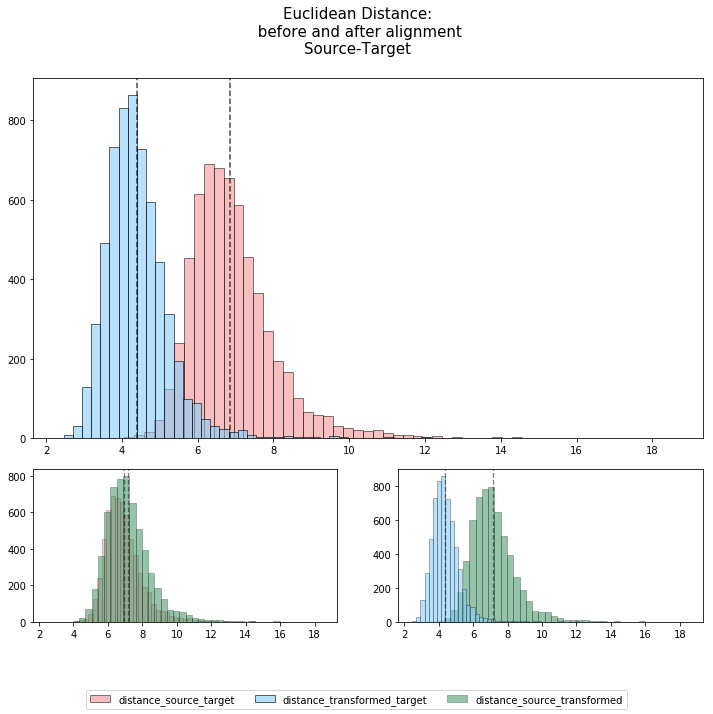

In [28]:
# Plot euclidian distances comparison before and after alignment
fig = plt.figure(figsize=(12, 10))
grid = plt.GridSpec(24, 4, hspace=0.5, wspace=0.5)
main_ax = fig.add_subplot(grid[:16, 0:])
x1_hist = fig.add_subplot(grid[-7:, :2], sharex=main_ax)
x2_hist = fig.add_subplot(grid[-7:, 2:], sharex=main_ax)

main_ax.hist(distance_source_target, 
             color = "lightcoral", bins=40, alpha=.5, 
             edgecolor='black', linewidth=1, label='distance_source_target')
main_ax.hist(distance_transformed_target, 
             color = "lightskyblue", bins=40, alpha=0.6, 
             edgecolor='black', linewidth=1, label='distance_transformed_target')
main_ax.axvline(np.mean(distance_source_target)-.05, color='black',alpha=0.7, linestyle='dashed', linewidth=1.5)
main_ax.axvline(np.mean(distance_transformed_target), color='black',alpha=0.7, linestyle='dashed', linewidth=1.5)

x1_hist.hist(distance_source_target, 
             color = "lightcoral", bins=40, alpha=0.4, 
             edgecolor='black', linewidth=.5) #, label='source_target'
x1_hist.hist(distance_source_transformed, 
             color = "seagreen", bins=40, alpha=0.5, 
             edgecolor='black', linewidth=.5, label='distance_source_transformed')
x1_hist.axvline(np.mean(distance_source_target), color='black',alpha=0.5, linestyle='dashed', linewidth=1.3)
x1_hist.axvline(np.mean(distance_source_transformed), color='black',alpha=0.5, linestyle='dashed', linewidth=1.3)

x2_hist.hist(distance_source_transformed, 
             color = "seagreen", bins=40, alpha=0.5,
             edgecolor='black', linewidth=.5) #, label='source_transformed'
x2_hist.hist(distance_transformed_target, 
             color = "lightskyblue", bins=40, alpha=0.6, 
             edgecolor='black', linewidth=.5) #, label='transformed_target'
x2_hist.axvline(np.mean(distance_source_transformed), color='black',alpha=0.5, linestyle='dashed', linewidth=1.3)
x2_hist.axvline(np.mean(distance_transformed_target), color='black',alpha=0.5, linestyle='dashed', linewidth=1.3)

plt.figlegend(loc = 'lower center', ncol=3, labelspacing=0.5) #bbox_to_anchor=(1.1, 1.05)
plt.suptitle('Euclidean Distance:\n before and after alignment\nSource-Target', fontsize=15);

#plt.savefig('Euclidean_Distance_Word_Embeddings.png');

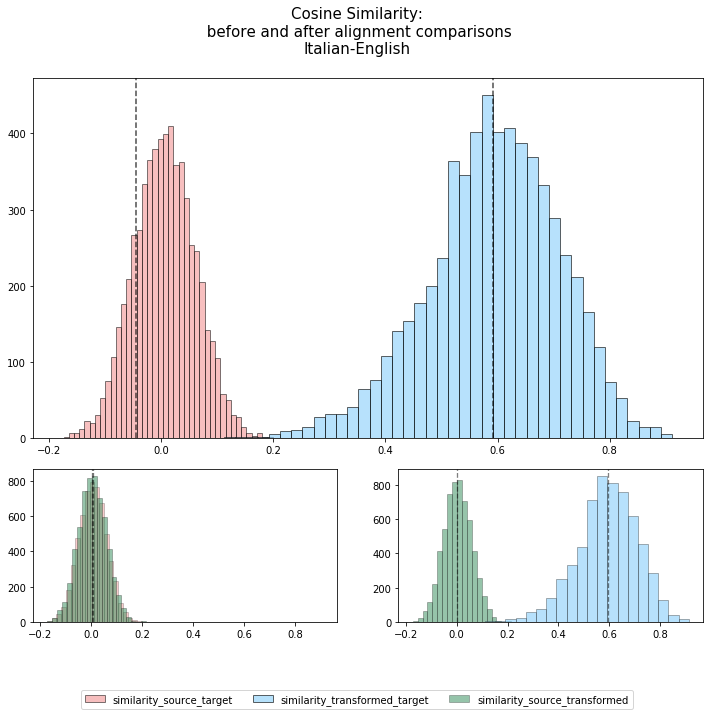

In [30]:
# Plot cosine similarities comparison before and after alignment
fig = plt.figure(figsize=(12, 10))
grid = plt.GridSpec(24, 4, hspace=0.5, wspace=0.5)
main_ax = fig.add_subplot(grid[:16, 0:])
x1_hist = fig.add_subplot(grid[-7:, :2], sharex=main_ax)
x2_hist = fig.add_subplot(grid[-7:, 2:], sharex=main_ax)

main_ax.hist(similarity_source_target, 
             color = "lightcoral", bins=40, alpha=.5, 
             edgecolor='black', linewidth=1, label='similarity_source_target')
main_ax.hist(similarity_transformed_target, 
             color = "lightskyblue", bins=40, alpha=0.6, 
             edgecolor='black', linewidth=1, label='similarity_transformed_target')
main_ax.axvline(np.mean(similarity_source_target)-.05, color='black',alpha=0.7, linestyle='dashed', linewidth=1.5)
main_ax.axvline(np.mean(similarity_transformed_target), color='black',alpha=0.7, linestyle='dashed', linewidth=1.5)
#main_ax.annotate(str(round(np.mean(distance_transformed_target),2)), xy=(2, 820), xytext=(4.55, 815))

x1_hist.hist(similarity_source_target, 
             color = "lightcoral", bins=20, alpha=0.4, 
             edgecolor='black', linewidth=.5) #, label='source_target'
x1_hist.hist(similarity_source_transformed, 
             color = "seagreen", bins=20, alpha=0.5, 
             edgecolor='black', linewidth=.5, label='similarity_source_transformed')
x1_hist.axvline(np.mean(similarity_source_target), color='black',alpha=0.5, linestyle='dashed', linewidth=1.3)
x1_hist.axvline(np.mean(similarity_source_transformed), color='black',alpha=0.5, linestyle='dashed', linewidth=1.3)

x2_hist.hist(similarity_source_transformed, 
             color = "seagreen", bins=20, alpha=0.5,
             edgecolor='black', linewidth=.5) #, label='source_transformed'
x2_hist.hist(similarity_transformed_target, 
             color = "lightskyblue", bins=20, alpha=0.6, 
             edgecolor='black', linewidth=.5) #, label='transformed_target'
x2_hist.axvline(np.mean(similarity_source_transformed), color='black',alpha=0.5, linestyle='dashed', linewidth=1.3)
x2_hist.axvline(np.mean(similarity_transformed_target), color='black',alpha=0.5, linestyle='dashed', linewidth=1.3)

plt.figlegend(loc = 'lower center', ncol=3, labelspacing=0.5) #bbox_to_anchor=(1.1, 1.05)
plt.suptitle('Cosine Similarity:\n before and after alignment comparisons\nItalian-English', fontsize=15);
#plt.savefig('Cosine_Similarity_Word_Embeddings_word2vec_ENG_IT_30k.png');

### 5. Apply transformation to the entire source vocabulary dataset

In [66]:
# apply transformation to source vocabulary
transformed_source = apply_transform(transformation, np.array(list(vocabulary_source.values())))
# check if the first vector shifthed or note
print("The source vocabulary shifted: {}".format(transformed_source[0][0] != list(vocabulary_source.items())[0][1][0]))

The source vocabulary shifted: True
